<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/code/Homework_09_Vesely.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01RAD Exercise 09

* Robust Regression - How to deal with Outliers and Leverages
* Very fast intro of Robust regression - M, MM, LTS, LWS


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import seaborn as sns

import statsmodels.api as sm



In [18]:
# --- Robust LWS Implementation ---
def lws(y, X, weights, niter=100):
    """Least Weighted Squares (LWS) estimator with iterations."""
    import numpy as np
    import pandas as pd
    # 1. Ensure inputs are numpy arrays
    if hasattr(y, 'values'): y = y.values
    if hasattr(X, 'values'): X = X.values
    if hasattr(weights, 'values'): weights = weights.values

    y = np.asarray(y, dtype=float)
    X = np.asarray(X, dtype=float)
    weights = np.asarray(weights, dtype=float)
    if y.ndim > 1 and y.shape[1] == 1: y = y.flatten()

    n, p = X.shape
    w_profile = np.sort(weights)[::-1]

    try: beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    except: beta = np.zeros(p)

    for _ in range(niter):
        residuals = y - X @ beta
        sq_res = residuals**2
        sorted_indices = np.argsort(sq_res)
        w_current = np.zeros(n)
        w_current[sorted_indices] = w_profile
        sqrt_w = np.sqrt(w_current)
        X_w = X * sqrt_w[:, np.newaxis]
        y_w = y * sqrt_w
        beta_new, _, _, _ = np.linalg.lstsq(X_w, y_w, rcond=None)
        if np.allclose(beta, beta_new, atol=1e-6):
            beta = beta_new
            break
        beta = beta_new
    return {'b': beta}

In [32]:
import numpy as np

def _lws_from_init(y, X, w_prof, beta_init, niter=50, tol=1e-6):
    """
    Vnitřní IRLS smyčka LWS, vychází z daného beta_init.
    Vrací (beta, w, residuals, obj).
    """
    y = np.asarray(y, dtype=float).ravel()
    X = np.asarray(X, dtype=float)
    w_prof = np.asarray(w_prof, dtype=float).ravel()

    n, p = X.shape
    beta = np.asarray(beta_init, dtype=float).ravel()

    # iterativní reweighting
    w_current = np.ones(n, dtype=float)

    for _ in range(niter):
        # 1) rezidua
        resid = y - X @ beta

        # 2) seřazení podle velikosti reziduí
        order = np.argsort(resid**2)      # od nejmenšího rezidua

        # 3) nové váhy podle pořadí
        w_new = np.zeros(n, dtype=float)
        w_new[order] = w_prof             # nejmenší rezidua dostanou nejvyšší váhy

        # 4) WLS z těchto vah
        mask = w_new > 0
        if mask.sum() <= p:
            # fallback – kdyby bylo moc málo nenulových vah
            mask = np.ones(n, dtype=bool)

        ww = w_new[mask]
        Xw = X[mask, :]
        yw = y[mask]

        # X' W X a X' W y
        WX = ww[:, None] * Xw            # W X
        XtWX = Xw.T @ WX                 # X' W X
        XtWy = Xw.T @ (ww * yw)          # X' W y

        try:
            beta_new = np.linalg.solve(XtWX, XtWy)
        except np.linalg.LinAlgError:
            beta_new, *_ = np.linalg.lstsq(WX, ww * yw, rcond=None)

        # 5) test konvergence
        if np.allclose(beta, beta_new, atol=tol, rtol=0.0):
            beta = beta_new
            w_current = w_new
            break

        beta = beta_new
        w_current = w_new

    # finální rezidua a vážená ztráta
    resid_final = y - X @ beta
    obj = np.sum(w_current * resid_final**2)

    return beta, w_current, resid_final, obj


def lws(y, X, weights_profile, niter=50, tol=1e-6,
        n_starts=50, random_state=None):
    """
    Robustní Least Weighted Squares (LWS) s vícenásobnými starty z p+1 bodů.

    - Nejprve se připraví váhový profil w_prof (seřazený sestupně, délka n).
    - Pro každý start:
        * vybere se náhodně podvzorek o velikosti p+1
        * spočítá se OLS na tomto podvzorku (beta_init)
        * spustí se IRLS (_lws_from_init)
    - Vybere se řešení s nejmenší váženou ztrátou ∑ w_i r_i^2.

    Parameters
    ----------
    y : array-like, shape (n,)
    X : array-like, shape (n, p)
    weights_profile : array-like
        váhový profil podle pořadí reziduí (není nutně délky n)
    niter : int
        max. počet IRLS iterací pro jeden start
    tol : float
        tolerance pro konvergenci beta
    n_starts : int
        počet náhodných startů (p+1 subsetů)
    random_state : int nebo None
        seed pro RNG, aby byly výsledky reprodukovatelné
    """
    # --- na numpy ---
    if hasattr(y, "values"):
        y = y.values
    if hasattr(X, "values"):
        X = X.values
    if hasattr(weights_profile, "values"):
        weights_profile = weights_profile.values

    y = np.asarray(y, dtype=float).ravel()
    X = np.asarray(X, dtype=float)
    w_prof = np.asarray(weights_profile, dtype=float).ravel()

    n, p = X.shape

    # --- připrav váhový profil: seřadit sestupně, doplnit / useknout na n ---
    w_prof = np.sort(w_prof)[::-1]   # největší váha -> nejmenší residuum
    if w_prof.size > n:
        w_prof = w_prof[:n]
    elif w_prof.size < n:
        w_prof = np.concatenate([w_prof, np.zeros(n - w_prof.size)])

    rng = np.random.default_rng(random_state)

    best_beta = None
    best_w = None
    best_resid = None
    best_obj = np.inf

    # --- vícenásobné starty z podvzorků velikosti p+1 ---
    for _ in range(max(n_starts, 1)):
        if n >= p + 1:
            subset_idx = rng.choice(n, p + 1, replace=False)
        else:
            subset_idx = np.arange(n)

        X_sub = X[subset_idx, :]
        y_sub = y[subset_idx]

        # OLS na p+1 bodech jako initial
        try:
            beta_init, *_ = np.linalg.lstsq(X_sub, y_sub, rcond=None)
        except np.linalg.LinAlgError:
            # fallback: začni z klasického OLS na všech datech
            beta_init, *_ = np.linalg.lstsq(X, y, rcond=None)

        beta, w, resid, obj = _lws_from_init(
            y, X, w_prof, beta_init, niter=niter, tol=tol
        )

        if obj < best_obj:
            best_obj = obj
            best_beta = beta
            best_w = w
            best_resid = resid

    return {
        "b": best_beta,
        "w": best_w,
        "residuals": best_resid,
        "obj": best_obj,
    }


In [33]:
# --- Setup for Task Solutions ---
# This cell loads necessary data and defines helper functions used in the tasks below.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# Guarded Magic & Display for Script Portability
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

if 'display' not in globals():
    def display(obj):
        print(obj)

# Load Data (StarsCYG)
try:
    dta = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data
    y_stars = dta['log.light']
    X_stars = sm.add_constant(dta['log.Te'])
    x_grid = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 200)
    X_grid = sm.add_constant(x_grid)
    print("StarsCYG data loaded successfully.")
except Exception as e:
    print(f"Warning: Could not load StarsCYG data: {e}")
    np.random.seed(42)
    dta = pd.DataFrame({'log.Te': np.random.normal(4, 0.5, 47), 'log.light': np.random.normal(5, 1, 47)})
    y_stars = dta['log.light']
    X_stars = sm.add_constant(dta['log.Te'])
    x_grid = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 200)
    X_grid = sm.add_constant(x_grid)
    print("Fallback synthetic data generated.")

# Helper: Least Trimmed Squares
def least_trimmed_squares(x, y, alpha=0.9, max_iter=1000, tol=1e-6, n_starts=100):
    """Least Trimmed Squares via C-steps with multiple random starts."""
    y_arr = np.asarray(y).ravel()
    X = np.asarray(x)
    if X.ndim == 1: X = X.reshape(-1, 1)
    X_design = sm.add_constant(X)
    n, p1 = X_design.shape
    h = int(np.ceil(alpha * n))
    if h <= p1: raise ValueError("alpha too small")
    best_obj = np.inf
    best_params = None
    rng = np.random.default_rng(42)

    for _ in range(n_starts):
        subset_idx = rng.choice(n, size=p1, replace=False)
        try: beta = np.linalg.lstsq(X_design[subset_idx], y_arr[subset_idx], rcond=None)[0]
        except: continue
        for _ in range(max_iter):
            residuals = y_arr - X_design @ beta
            order = np.argsort(residuals ** 2)
            keep = order[:h]
            X_h = X_design[keep]
            y_h = y_arr[keep]
            try: beta_new = np.linalg.lstsq(X_h, y_h, rcond=None)[0]
            except: break
            if np.linalg.norm(beta_new - beta) < tol:
                beta = beta_new
                break
            beta = beta_new
        residuals = y_arr - X_design @ beta
        order = np.argsort(residuals ** 2)
        keep = order[:h]
        obj = np.sum(residuals[keep] ** 2)
        if obj < best_obj:
            best_obj = obj
            best_params = beta
    if best_params is None: best_params = sm.OLS(y_arr, X_design).fit().params
    return best_params, None

StarsCYG data loaded successfully.


# Task Solutions

In [34]:
def Weights2(n, g, h):
    """
    Generate decreasing weight profile for LWS.

    0 .. g-1 : "plné" váhy, hladký pokles 1 -> ~0.9
    g .. h-1 : rychlý pokles ~0.9 -> >0
    h .. n-1 : 0
    """
    import numpy as np

    w = np.zeros(n, dtype=float)
    # 1) plný úsek: 1 ->  0.9
    if g > 0:
        if g == 1:
            w[0] = 1.0
        else:
            # endpoint=False zajistí, že poslední hodnota < 0.9
            w[:g] = np.linspace(1.0, 0.9, g, endpoint=False)
    # 2) rychle klesající úsek: 0.9 -> >0 (0 bude až od indexu h)
    if h > g:
        m = h - g
        if m == 1:
            w[g] = 0.9
        else:
            # opět endpoint=False, takže poslední hodnota > 0
            w[g:h] = np.linspace(0.9, 0.0, m, endpoint=False)
    # 3) od h do n zůstávají nuly
    return w

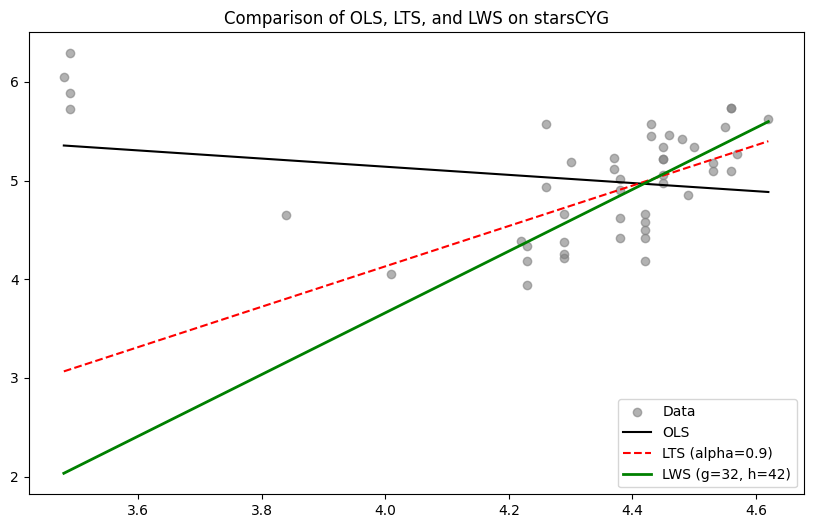

--- LWS Parameter Sensitivity (Grid Search) ---
    g   h  Intercept     Slope  MAD_Resid
7  37  42  -8.487116  3.045195   0.297288
4  32  42  -8.847990  3.126745   0.310419
3  32  39  -9.342906  3.236450   0.311084
1  28  42  -8.952584  3.150727   0.316174
6  37  39  -9.024212  3.164625   0.316830
2  28  44  -5.935405  2.475529   0.328459
5  32  44  -5.563284  2.389571   0.334693
8  37  44  -4.112546  2.058753   0.334700
0  28  39 -10.782010  3.557755   0.336931


In [36]:
# Task 1 & 2: LWS Implementation and Comparison

n_stars = len(y_stars)
g_param = int(0.7 * n_stars)
h_param = int(0.9 * n_stars)
w_stars = Weights2(n_stars, g_param, h_param)

lws_fit = lws(y_stars, X_stars, w_stars, niter=100)
lws_params = lws_fit['b']
ols_re = sm.OLS(y_stars, X_stars).fit()
lts_p, _ = least_trimmed_squares(dta['log.Te'], dta['log.light'], alpha=0.9, max_iter=20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(dta['log.Te'], dta['log.light'], color='gray', alpha=0.6, label='Data')
ax.plot(x_grid, ols_re.predict(X_grid), color='black', label='OLS')
ax.plot(x_grid, X_grid @ lts_p, color='red', linestyle='--', label='LTS (alpha=0.9)')
ax.plot(x_grid, X_grid @ lws_params, color='green', linewidth=2, label=f'LWS (g={g_param}, h={h_param})')
ax.set_title('Comparison of OLS, LTS, and LWS on starsCYG')
ax.legend()
plt.show()

# Parameter Sensitivity (Grid Search over g, h)
print("--- LWS Parameter Sensitivity (Grid Search) ---")
results_grid = []
g_range = [int(p * n_stars) for p in [0.6, 0.7, 0.8]]
h_range = [int(p * n_stars) for p in [0.85, 0.9, 0.95]]

for g_try in g_range:
    for h_try in h_range:
        if h_try <= g_try: continue
        w_try = Weights2(n_stars, g_try, h_try)
        res = lws(y_stars, X_stars, w_try, niter=20)
        resid = y_stars - X_stars @ res['b']
        mad_res = stats.median_abs_deviation(resid)
        results_grid.append({'g': g_try, 'h': h_try, 'Intercept': res['b'][0], 'Slope': res['b'][1], 'MAD_Resid': mad_res})

display(pd.DataFrame(results_grid).sort_values('MAD_Resid'))

Running simulation: 0.0% Outliers...
Running simulation: 5.0% Outliers...
Running simulation: 10.0% Outliers...


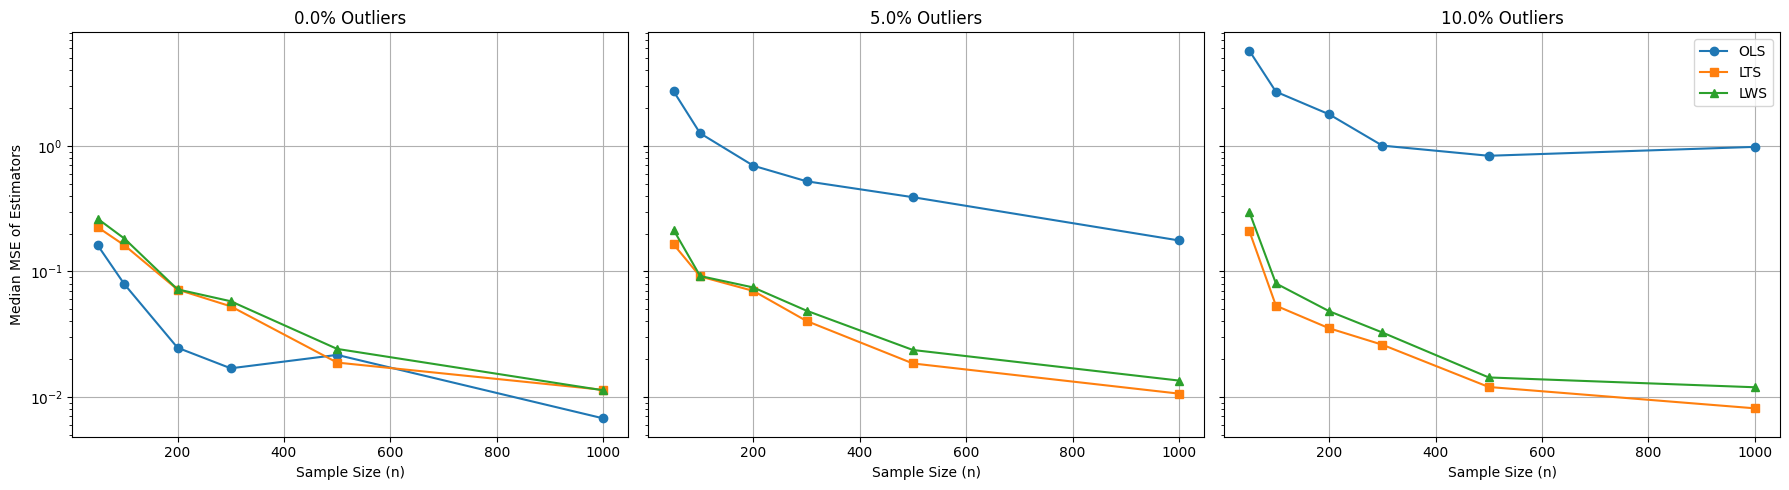

--- Summary Results Table (Median MSE) ---
Method              LTS       LWS       OLS
Outliers N                                 
0.00     50    0.224962  0.262663  0.161422
         100   0.161799  0.182969  0.079235
         200   0.071719  0.071988  0.024683
         300   0.052745  0.057889  0.016923
         500   0.018799  0.024149  0.021640
         1000  0.011401  0.011301  0.006758
0.05     50    0.164598  0.214700  2.728547
         100   0.091231  0.091949  1.260813
         200   0.069971  0.074537  0.695519
         300   0.040326  0.048699  0.522737
         500   0.018495  0.023676  0.390396
         1000  0.010635  0.013515  0.176618
0.10     50    0.210002  0.297750  5.733024
         100   0.053368  0.080259  2.702245
         200   0.035272  0.048236  1.785578
         300   0.026076  0.032644  1.005457
         500   0.012012  0.014312  0.834651
         1000  0.008123  0.011952  0.982570


In [6]:
# Task 3, 4, 5: Comprehensive Simulation (Consistency & Outlier Handling)

ns = [50, 100, 200, 300, 500,1000]
n_reps = 100
outlier_settings = [0.0, 0.05, 0.10]
beta0 = np.array([2, 3, -2, 2, 3])
all_results = []

for out_pct in outlier_settings:
    print(f"Running simulation: {out_pct*100}% Outliers...")
    for n in ns:
        mse_ols, mse_lts, mse_lws = [], [], []
        n_out = int(n * out_pct)
        g_lws, h_lws = int(0.8 * n), int(0.9 * n)
        w_lws = Weights2(n, g_lws, h_lws)

        for _ in range(n_reps):
            X = np.column_stack([np.ones(n), np.random.binomial(10, 0.3, n)+1, np.random.normal(10, 2, n), np.random.normal(20, 3, n), np.random.exponential(8, n)])
            y = X @ beta0 + np.random.normal(0, 1, n)
            if n_out > 0: y[np.random.choice(n, n_out, replace=False)] += 20

            try: b = np.linalg.lstsq(X, y, rcond=None)[0]; mse_ols.append(np.mean((b - beta0)**2))
            except: pass
            try: b, _ = least_trimmed_squares(X[:, 1:], y, alpha=0.9, max_iter=5, n_starts=1); mse_lts.append(np.mean((b - beta0)**2))
            except: pass
            try: lws_res = lws(y, X, w_lws, niter=5); mse_lws.append(np.mean((lws_res['b'] - beta0)**2))
            except: pass

        if mse_ols: all_results.append({'Outliers': out_pct, 'N': n, 'Method': 'OLS', 'Median_MSE': np.median(mse_ols)})
        if mse_lts: all_results.append({'Outliers': out_pct, 'N': n, 'Method': 'LTS', 'Median_MSE': np.median(mse_lts)})
        if mse_lws: all_results.append({'Outliers': out_pct, 'N': n, 'Method': 'LWS', 'Median_MSE': np.median(mse_lws)})

df_results = pd.DataFrame(all_results)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
methods = ['OLS', 'LTS', 'LWS']
markers = {'OLS': 'o', 'LTS': 's', 'LWS': '^'}
for i, pct in enumerate(outlier_settings):
    ax = axes[i]
    subset = df_results[df_results['Outliers'] == pct]
    if subset.empty: continue
    for method in methods:
        data = subset[subset['Method'] == method]
        ax.plot(data['N'], data['Median_MSE'], marker=markers[method], label=method)
    ax.set_title(f'{pct*100}% Outliers'); ax.set_xlabel('Sample Size (n)'); ax.set_yscale('log'); ax.grid(True)
    if i == 0: ax.set_ylabel('Median MSE of Estimators')
    if i == 2: ax.legend()
plt.tight_layout(); plt.show()

print("--- Summary Results Table (Median MSE) ---")
try:
    pivot_res = df_results.pivot_table(index=['Outliers', 'N'], columns='Method', values='Median_MSE')
    display(pivot_res)
except:
    print(df_results)